<a href="https://colab.research.google.com/github/katty-anay/Fluid_mechanics_/blob/main/Report-Stokes-AMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [199]:
# This program has been written with a template from
# DD2365 Advanced Computation in Fluid Mechanics,
# KTH Royal Institute of Technology, Stockholm, Sweden.

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This report has been written by Katty Raboanarijaona (20021105-T545)

# **Set up environment**

In [200]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force.

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions.

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero.

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$,

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$,
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional.

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$.

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$,
with the error indicator

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$,

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible.

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

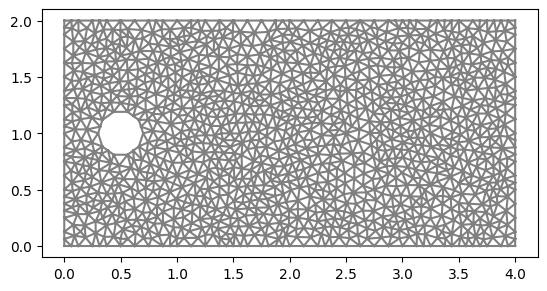

In [201]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 0.5
yc = 0.5*H
rc = 0.2

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
init_no_levels = 0
for i in range(0,init_no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [202]:
# Generate mixed finite element spaces (for primal velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

# Generate mixed finite element spaces (for adjoint velocity and pressure)
VEa = VectorElement("CG", mesh.ufl_cell(), 2)
QEa = FiniteElement("CG", mesh.ufl_cell(), 1)
WEa = VEa * QEa

Wa = FunctionSpace(mesh, WEa)
Va = FunctionSpace(mesh, VEa)
Qa = FunctionSpace(mesh, QEa)

# Define adjoint trial and test functions
wa = Function(Wa)
(phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
(va, qa) = TestFunctions(Wa)

**Define boundary conditions**

In [203]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())

# Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problems**

In [204]:
# Set boundary penalty parameter gamma
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

# Set force in primal problem
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Set data that describe functional that defines the adjoint problem
#psi1 = Expression(("exp(-10.0*(pow(x[0]-0.5,2) + pow(x[1]-1.0,2)))","0.0"), element = V.ufl_element())
#psi2 = Expression("exp(-10.0*(pow(x[0]-0.5,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
psi2 = Expression("0.0", element = Q.ufl_element())
phi3 = Expression(("1.0","0.0"), element = V.ufl_element()) #drag
#phi3 = Expression(("0.0","1.0"), element = V.ufl_element()) #lift

# Define primal variational problem on residual form: r(u,p;v,q) = 0
res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx +
        gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

# Solve primal algebraic system
solve(res == 0, w)

# Define adjoint variational problem on residual form: r(u,p;v,q) = 0
res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx +
          gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds
         - inner(va, psi1)*dx - qa*psi2*dx )

# Solve adjoint algebraic system
solve(res_a == 0, wa)

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


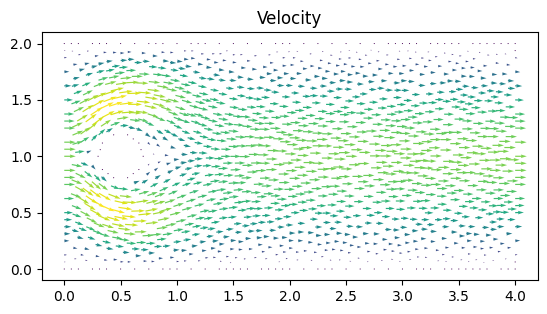

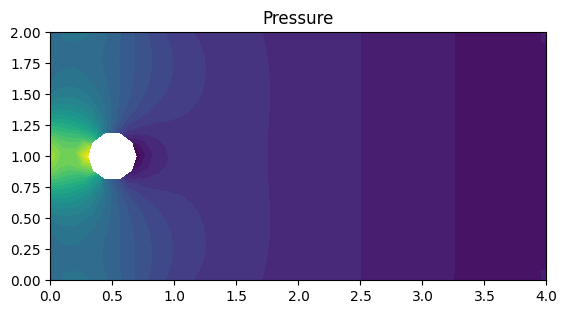

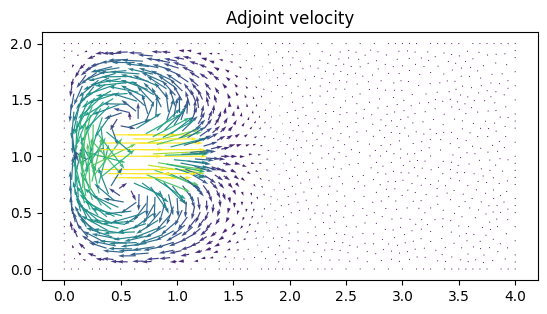

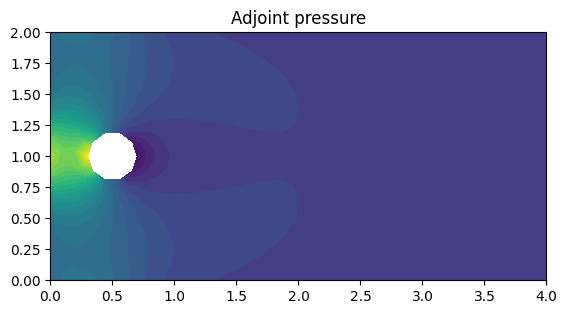

In [205]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")
file_phi = File("results-Stokes/phi.pvd")
file_theta = File("results-Etokes/theta.pvd")

# Initiate functions to save and visualize the solutions
u_fcn = project(u, V)
p_fcn = project(p, Q)
phi_fcn = project(phi, V)
theta_fcn = project(theta, Q)

# Save solution to file
file_u << u_fcn
file_p << p_fcn
file_phi << phi_fcn
file_theta << theta_fcn

# Plot solution
plt.figure()
plot(u_fcn, title="Velocity")

plt.figure()
plot(p_fcn, title="Pressure")

plt.figure()
plot(phi_fcn, title="Adjoint velocity")

plt.figure()
plot(theta_fcn, title="Adjoint pressure")

plt.show()

**Compute error indicators**

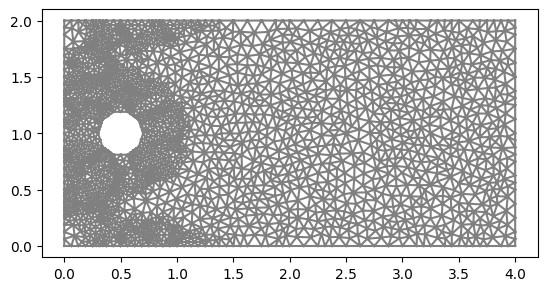

Total error = -3.1705564556325217e-13


In [206]:
# Define function space over the elements of the mesh
WDG = FunctionSpace(W.mesh(), "DG", 0)
elm = TestFunction(WDG)
err_ind = Function(WDG)

# Compute local error indicators over the cells of the mesh
local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx )
err_ind.vector()[:] = assemble(local_error)
err_ind_abs = np.abs(err_ind.vector())
err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()]
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx -
               gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

tot_err = assemble(err_ind_sum)
s = 'Total error = ' + repr(tot_err)
print(s)

# **Original domain vs New domain (adjoint problem for drag force)**

Mesh refinement :

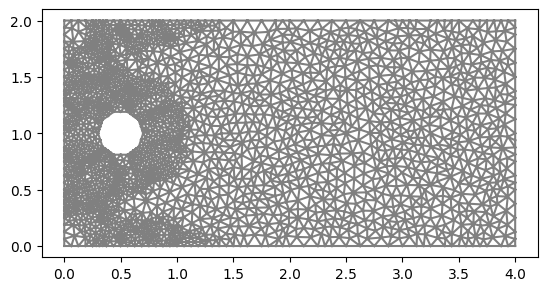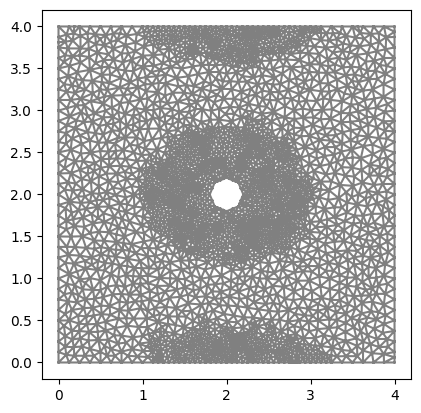

Solutions :

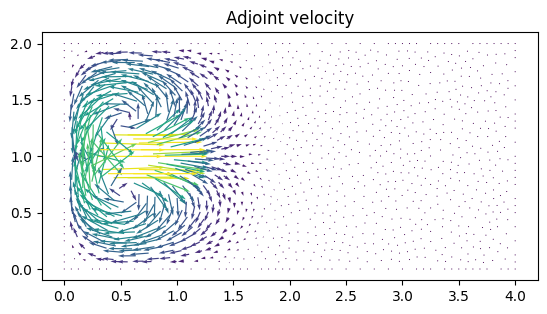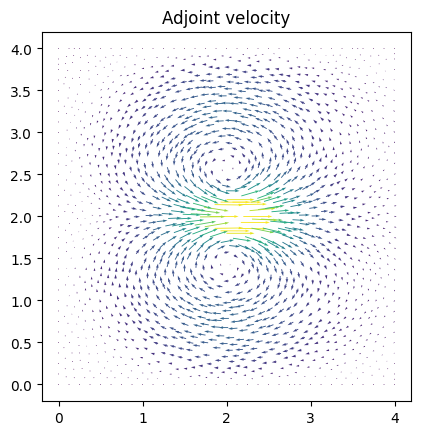

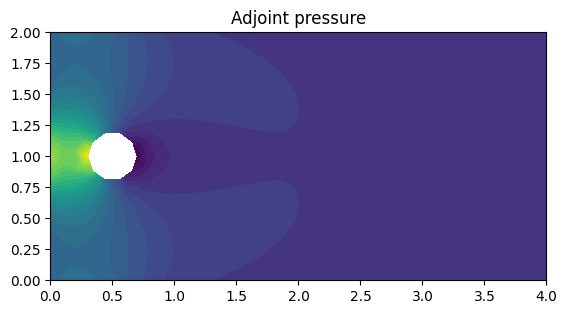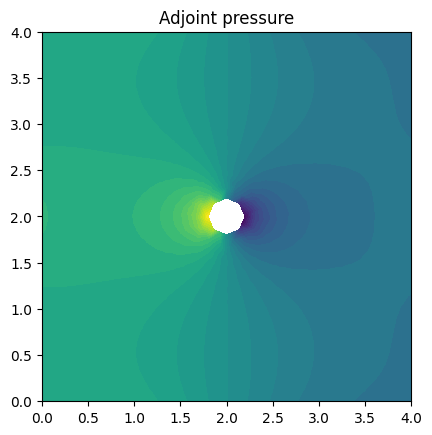

Total error for the rectangle : 0.015449204490893037

Total error for the square : 0.005544566319844384


# **Change of the functional**

When changing psi_2 for psi2 = Expression("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element()) :

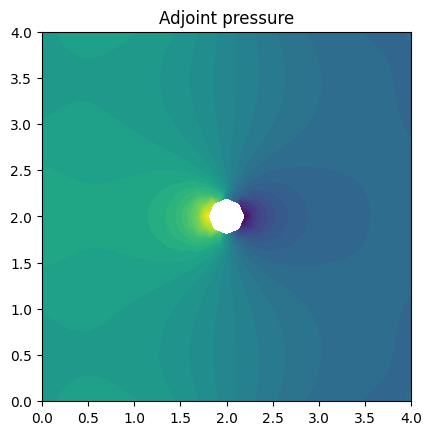


When changing psi_1 for psi_1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-2.0,2)))","0.0"), element = V.ufl_element())

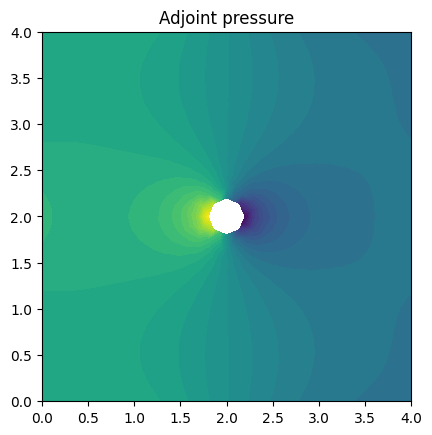

When changing psi_3=phi_3 to observe for the lift force which means phi_3 = Expression(("0.0","1.0"), element = V.ufl_element() :

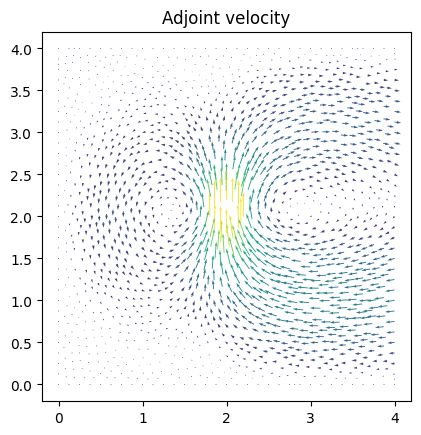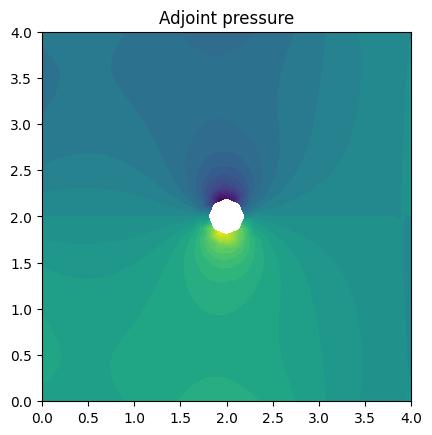



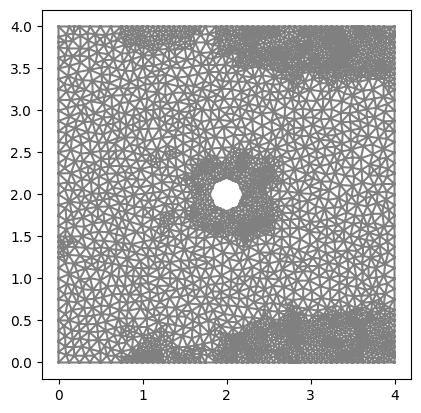

Total error = -0.0010466606356027226

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

## **Change of domain**

When we take the adjoint problem for the drag force, which means psi_1 = (0,0), psi_2 = 0 and psi_3 = (1,0) we observe that changing the domain leads to different local mesh refinement aspect and slightly different solutions.
Indeed, when the hole is close to the left boundary (which is the inflow boundary) the local mesh refinement is effective over the inflow boundary. Whereas when the hole is in the middle of the domain, the local mesh refinement is centered on the hole and in the center up and bottom. In the case where the hole is not centered, after the hole (on its right side) the adjoint pressure is very low and less representative leading to a higher total error.

## **Change of functional**

When we change the adjoint problem for the drag force (and centered hole), which means psi_1 = (0,0), psi_2 = 0 and psi_3 = (1,0) with different psi_1 and psi_2 values, we obtain no significant effects on the solutions and local mesh refinement.

Indeed when we observe for the drag force, the psi_1 and psi_2 do not affect the solutions.

When we change psi_3 we have different solutions because we focus on the lift (for example) and not the drag force. This leads to a different pattern of mesh refinement, indeed the local refinement around the hole is more narrow for the lift force but the up and down refinement are larger. For the drag the local refinement area was larger around the hole.


# **Total error**

For a resolution of h=1/64, with the original psi_1,psi_2 and drag force (psi_3) we obtain a thinner mesh :

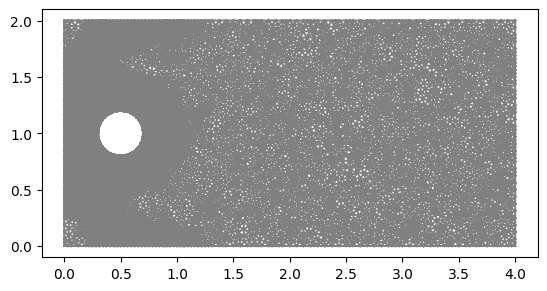

Here, the total error is 0.0004830970459304171.

For h=1/32, the total error was 0.015449204490893037.

But if we take a finite element function for the adjoint problem in the test space of the primal problem then, we would obtain :

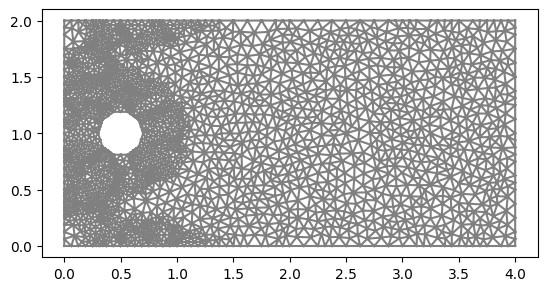

Here the total error is -3.1705564556325217e-13 which is abnormally really close to zero. This is not true and it is due to the fact that we approximate the exact adjoint solution with a finite element function in the test space of the primal problem, for which the weak form is zero.